## Sampling from the FNN Output

This is only for sampling from the FNN output, needs to be integrated in the general fnn sampling notebook.

In [22]:


import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
from utils import createFlowDataset, subps 
from glob import glob
from time import time

import sys

from torchvision import models
import torch.nn as nn

print(torch.__version__)  # E.g., '1.10.0'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

from fnn import microns
from numpy import full, concatenate

model, ids = microns.scan(session=6, scan_idx=4)
SUFFIX = "fnn07_6_4" 

################# SET PARAMS ##########################
n_fmaps_to_sample = 1
samples_per_fmap = 2000
seed = 3

################# MORE PARAMS #########################
LAYER_TYPE = 'act'
MAX_SIDE = 32

# Flow stimuli parameters
scl_factor = 0.7
N_INSTANCES = 3
trial_len = 75 // 2  # Number of frames
stride = 1

## SAMPLING
fmap_samp_method = 'rnd'
neur_samp_method = 'rnd'


2.6.0+cu124
Using device: cuda


In [23]:


# Define the input shape expected by the model
input_shape = (144, 256)

tot_stims 88
frames_per_stim 37
*INSTANCE 0 ...........
*INSTANCE 1 ...........
*INSTANCE 2 ...........


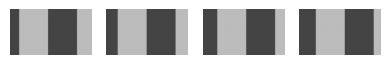

In [24]:

############# LOAD FLOW STIM FRAMES #################

orig_shape = (800, 600)

mydirs = list(map(str, range(0, 360, 45)))
categories = ['grat_W12', 'grat_W1', 'grat_W2',
              'neg1dotflow_D1_bg', 'neg3dotflow_D1_bg', 'neg1dotflow_D2_bg', 'neg3dotflow_D2_bg',
              'pos1dotflow_D1_bg', 'pos3dotflow_D1_bg', 'pos1dotflow_D2_bg', 'pos3dotflow_D2_bg']

topdir = 'flowstims'
NDIRS = len(mydirs)
tot_stims = len(categories) * NDIRS
print('tot_stims', tot_stims, flush=True)
frames_per_stim = (trial_len // stride)
print('frames_per_stim', frames_per_stim)

# Create flow datasets (placeholder function)
flow_datasets = createFlowDataset(categories, topdir, mydirs, orig_shape, input_shape,
                                  scl_factor, N_INSTANCES, trial_len, stride)

# Show example of sequence of frames generated for a stimulus trial
n_frames_to_show = 4
interval = 8

f, axes = subps(1, n_frames_to_show, 1, 1)
for i in range(n_frames_to_show):
    ax = axes[i]
    img = flow_datasets[0][i * interval].reshape(input_shape)
    ax.imshow(img, vmin=0, vmax=255, cmap='gray')
    ax.axis('off')

f.tight_layout()
plt.show()

In [25]:
print(flow_datasets[0].shape)
print(144*256)
print(3256 / 8 / 37)

(3256, 36864)
36864
11.0


In [26]:
def reshape_flow_img(raveled_1chan_img):
    img = raveled_1chan_img.reshape((37, input_shape[0], input_shape[1]))
    #img = np.stack([img, img, img], axis=0)  # Convert to 3 channels
    img = img.astype(np.uint8)
    return img



In [27]:

####################### COMPUTE ################



TOL = 0

n_orig_imgs = tot_stims
n_shifts = frames_per_stim
n_shifted_imgs = n_orig_imgs * n_shifts

print('tot # of images:', n_orig_imgs, '*', n_shifts, '=', n_shifted_imgs)


layer_outputs = []
instance_layer_outputs = []

for li in range(1):
    shape = [n_shifted_imgs] + [8221,1,1]
    layer_outputs.append(np.zeros(shape, dtype='float32'))
    shape_inst = np.append([N_INSTANCES], shape)
    instance_layer_outputs.append(np.zeros(shape_inst, dtype='float32'))

for insti in range(N_INSTANCES):
    extX = flow_datasets[insti]
    print(extX.shape)
    assert extX.shape[0] == n_shifted_imgs

    print('INSTANCE', insti)
    start0 = time()
    layer_output = []
    layer_output.append([])

    for seq_idx in range(int(len(extX)/37)):
        start = time()

        # Prepare batch
        sequence = extX[seq_idx*37:(seq_idx+1)*37]

        sequence = reshape_flow_img(extX[seq_idx*37:(seq_idx+1)*37])


        # Collect outputs per layer

        output = model.predict(stimuli=sequence)
        #print(output.shape)
        #output = output.reshape((37, 144, 256))
        
        # Crop the output if needed


        layer_output[0].append(output)

        print('(%.1fs) ' % (time() - start), end='', flush=True)
    print(' Tot time = %.1f' % (time() - start0), flush=True)

    # After processing all batches for this instance, concatenate outputs
    for li in range(1):
        # print(li)
        # print([l.shape for l in layer_output[li]])
        layer_output[li] = np.expand_dims(np.expand_dims(np.concatenate(layer_output[li], axis=0), axis=2), axis=3)
        print(layer_output[li].shape)
        layer_outputs[li] += layer_output[li]
        instance_layer_outputs[li][insti] = layer_output[li]


# Average over instances
for li in range(1):
    layer_outputs[li] /= N_INSTANCES

tot # of images: 88 * 37 = 3256
(3256, 36864)
INSTANCE 0
(0.5s) (0.4s) (0.4s) (0.4s) (0.4s) (0.5s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.5s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.5s) (0.4s) (0.5s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.5s) (0.7s) (0.5s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.5s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s)  Tot time = 37.4
(3256, 8221, 1, 1)
(3256, 36864)
INSTANCE 1
(0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.4s) (0.5s) (0.5s) (0.5s) (0.5s) (0.5s) (0.4s) (0.4s) (0.4s) (0.4s) 

In [28]:
################### SUMMARIZE ACTIVITY ###########

print('Activities per img:', end=' ')
all_neurons_maxs = []
all_neurons_means = []
all_per_img_output = []
for li in range(1):
    print(li, end='', flush=True)
    layer_output_ = layer_outputs[li].copy()

    layer_output_[layer_output_ < 0] = 0

    nfmaps = layer_output_.shape[3]
    # Reshape to [n_orig_imgs, n_shifts, nfmaps, -1]
    orig_per_img_output = np.moveaxis(layer_output_, -1, 1).reshape([n_orig_imgs, n_shifts, nfmaps, -1])
    orig_per_img_output = np.moveaxis(orig_per_img_output, 1, -1)

    # Normalize each image by the max
    layer_output_ /= np.maximum(layer_output_.max((1, 2, 3), keepdims=True), 1e-8)

    per_img_output = np.moveaxis(layer_output_, -1, 1).reshape([n_orig_imgs, n_shifts, nfmaps, -1])
    per_img_output = np.moveaxis(per_img_output, 1, -1)

    tot_n_neurons = np.prod(layer_output_.shape[1:])

    neurons_maxs = np.zeros(per_img_output.shape[1:3])
    neurons_means = np.zeros(per_img_output.shape[1:3])

    for imi in range(n_orig_imgs):
        im_avgs = per_img_output[imi].mean(2)  # Averaging across time
        neurons_maxs = np.maximum(neurons_maxs, im_avgs)
        neurons_means += im_avgs
    neurons_means /= n_orig_imgs

    idxs = neurons_maxs.mean(1).argsort()

    if li == 0:
        all_neurons_maxs = neurons_maxs
        all_neurons_means = neurons_means
        all_per_img_output = orig_per_img_output
    else:
        all_neurons_maxs = np.concatenate([all_neurons_maxs, neurons_maxs], 0)
        all_neurons_means = np.concatenate([all_neurons_means, neurons_means], 0)
        all_per_img_output = np.concatenate([all_per_img_output, orig_per_img_output], 1)

Activities per img: 0

In [29]:
############# SAMPLE NEURONS ###########

nfmaps, n_neurons_per_fmap = all_neurons_maxs.shape
layer_is_per_fmap = np.concatenate([li * np.ones(nf) for li, nf in enumerate([1])])
np.random.seed(seed)

maxsmean = all_neurons_maxs.mean(1)
nonzero_indices = (~np.isclose(maxsmean, 0)).sum()
n_fmaps_to_sample_ = min(n_fmaps_to_sample, nonzero_indices)
print(n_fmaps_to_sample)
if fmap_samp_method == 'maxFr' or fmap_samp_method == 'rnd':
    probabilities = maxsmean / maxsmean.sum()
    top_fmaps = np.random.choice(range(nfmaps), n_fmaps_to_sample_, replace=False)#TODO, p=probabilities)
else:
    raise ValueError('Invalid fmap_samp_method')

# Pick active neurons in each of these feature maps
sampled_neurons = []

samples_per_fmap = min(samples_per_fmap, all_neurons_means.shape[1])
print(samples_per_fmap)
for fi in top_fmaps:
    if neur_samp_method == 'maxNr' or neur_samp_method == 'rnd':
        neuron_vals = all_neurons_maxs[fi]
        nonzero_neurons = (~np.isclose(neuron_vals, 0)).sum()
        samples_per_fmap_ = min(samples_per_fmap, nonzero_neurons)
        probabilities = neuron_vals / neuron_vals.sum()
        top_nis = np.random.choice(range(n_neurons_per_fmap), samples_per_fmap_, replace=False)#TODO, p=probabilities)
    else:
        raise ValueError('Invalid neur_samp_method')
    sampled_neurons += list(fi * n_neurons_per_fmap + top_nis)
sampled_neurons = np.array(sampled_neurons)
n_neurons_to_pick = len(sampled_neurons)
print(n_neurons_to_pick)

1
2000
2000


In [30]:

######### BUILD TENSOR ##########

def get_neuron_pos(ni):
    """From sampled indices ni, get original indices back (layer index, fmap, posi, posj, raveled_idx)"""
    fi = ni // n_neurons_per_fmap
    li = int(layer_is_per_fmap[fi])
    ij = ni % n_neurons_per_fmap
    h, w, _ = (8221, 1, 1)
    ii = ij // w
    jj = ij % w
    return li, fi, ii, jj, ij

assert n_orig_imgs // NDIRS == len(categories)

tensorX = np.zeros((n_neurons_to_pick, len(categories), NDIRS, n_shifts))
neurons_used = np.empty((n_neurons_to_pick, 5), dtype='int')

# Collect PSTs for those sampled neurons
for nii, ni in enumerate(sampled_neurons):
    li, fi, ii, jj, posi = get_neuron_pos(ni)
    neurons_used[nii] = [li, fi, ii, jj, posi]

    for cati in range(len(categories)):
        pst = all_per_img_output[cati * NDIRS: (cati + 1) * NDIRS, fi, posi, :]
        tensorX[nii, cati] = pst

#SUFFIX = f"{model_name}_{LAYER_TYPE}_i{N_INSTANCES}_n{n_neurons_to_pick}_SCL{str(scl_factor).replace('.', '_')}_TL{trial_len}_{'_'.join(block)}_{fmap_samp_method}_{neur_samp_method}"


#print(SUFFIX)


if seed > 0:
    SUFFIX += f'_seed{seed}'
print(tensorX.shape)
print(neurons_used.shape)

SUFFIX += f'_{fmap_samp_method}_{neur_samp_method}'

directory = '../data/sampled_data'
os.makedirs(directory, exist_ok=True)

if os.path.exists(f'../data/sampled_data/tensor4d_{SUFFIX}.npy'):
    print("Files already exist, please delete them to prevent conflicts.")
else:
    
    np.save(f'../data/sampled_data/tensor4d_{SUFFIX}.npy', tensorX)
    print(f'tensor4d_{SUFFIX}.npy Saved.')

    np.save(f'../data/sampled_data/neurons_used_{SUFFIX}.npy', neurons_used)
    print(f'neurons_used_{SUFFIX}.npy Saved.')

(2000, 11, 8, 37)
(2000, 5)
tensor4d_fnn07_6_4_seed3_rnd_rnd.npy Saved.
neurons_used_fnn07_6_4_seed3_rnd_rnd.npy Saved.
